Story:
* Giant planets around M dwarf is rare

https://docs.google.com/document/d/1ac3Ei_31-UzBYVrhJATnpB1RVMSr5qAoW6NCSSfo0bY/edit?usp=sharing

In [1]:
import json
from urllib.request import urlopen

def get_exofop_json(target_name):
    url = f"https://exofop.ipac.caltech.edu/tess/target.php?id={target_name}&json"
    print(f"Querying data from exofop:\n{url}")
    response = urlopen(url)
    data_json = json.loads(response.read())
    return data_json

In [2]:
target_name = "TOI 5671"
data_json = get_exofop_json(target_name.replace(' ', '-'))
tic_params = data_json['stellar_parameters'][1]

Querying data from exofop:
https://exofop.ipac.caltech.edu/tess/target.php?id=TOI-5671&json


In [3]:
Rs = float(tic_params['srad'])
Ms = float(tic_params['mass'])
teff = float(tic_params['teff'])
logg = float(tic_params['logg'])
Rs, Ms, teff, logg

(0.408427, 0.400962, 3380.0, 4.81894)

In [4]:
planet_params = data_json['planet_parameters'][1]
period = float(planet_params['per']) 
t0 = float(planet_params['epoch'])
t14 = float(planet_params['dur'])
period, t0, t14

(3.3079817, 2459685.753346, 1.666)

In [5]:
import astropy.units as u

from astropy.units import Quantity
from astropy.constants import G
from numpy import pi, sin, sqrt

def mp_from_kiepms(k, i, e, p, mstar):
    """Calculates the planet's mass from RV parameters.

    Parameters
    ----------
    k: float, ndarray, or Quantity
        RV semiamplitude [m/s]
    i: float, ndarray, or Quantity
        Inclination [rad]
    e: float, ndarray, or Quantity
        Eccentricity [-]
    p: float, ndarray, or Quantity
        Orbital period [d]
    mstar: float, ndarray, or Quantity
        Stellar mass [Solar mass]

    Returns
    -------
    Planet mass [M_Jup]
    """
    k = k.to(u.m/u.s) if isinstance(k, Quantity) else k * u.m/u.s
    i = i.to(u.rad) if isinstance(i, Quantity) else i*u.rad
    p = p.to(u.s) if isinstance(p, Quantity) else (p*u.day).to(u.s)
    mstar = mstar.to(u.kg) if isinstance(mstar, Quantity) else (mstar*u.M_sun).to(u.kg)
    return (k * (p/(2*pi*G)) ** (1/3) * mstar ** (2 / 3) / sin(i) * sqrt((1 - e ** 2))).to(u.M_jup).value

k_rv = 245# m/s
inc = pi/2
ecc = 0
mass = mp_from_kiepms(k_rv, inc, ecc, period, Ms)
mass

0.9766625478769406

## NExSci

In [6]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
import pandas as pd
from pathlib import Path

redownload = False

fp = '../data/nexsci_data.csv'
if redownload or not Path(fp).exists():
    #pstable combines data from the Confirmed Planets and Extended Planet Parameters tables
    tab = NasaExoplanetArchive.query_criteria(table="pscomppars", 
    #                                          where="discoverymethod like 'Transit'"
    )
    df = tab.to_pandas()                                        
    df.to_csv(fp, index=True)
    
else:
    df = pd.read_csv(fp, index_col=0)
    df.index.name = 'index'
df.head()

/tmp/ipykernel_24461/1112017024.py:17: DtypeWarning: Columns (70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fp, index_col=0)


,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,discoverymethod,disc_locale,...,sy_pmra,sy_pmraerr1,sy_pmraerr2,sy_pmrastr,x,y,z,htm20,sky_coord.ra,sky_coord.dec
index,,,,,,,,,,,,,,,,,,,,,
0,OGLE-2016-BLG-1227L b,b,OGLE-2016-BLG-1227L,NaN,NaN,NaN,2020-03,2020,Microlensing,Ground,...,NaN,NaN,NaN,NaN,-0.063824,-0.828921,-0.555712,-768415656,265.597125,-33.759778
1,Kepler-276 c,c,Kepler-276,NaN,NaN,TIC 138213510,2014-02,2013,Transit,Space,...,7.99553,0.051581,-0.051581,7.9955300&plusmn;0.0515805,0.310575,-0.711954,0.629813,1302657699,293.568197,39.036312
2,Kepler-829 b,b,Kepler-829,NaN,NaN,TIC 123451768,2016-05,2016,Transit,Space,...,7.93777,0.040833,-0.040833,7.9377700&plusmn;0.0408326,0.157566,-0.720680,0.675124,-792260935,282.332831,42.463813
3,K2-283 b,b,K2-283,NaN,NaN,TIC 266017624,2018-12,2018,Transit,Space,...,-10.97340,0.053624,-0.053624,-10.9734000&plusmn;0.0536244,0.959702,0.224997,0.168368,609813555,13.194368,9.692918
4,Kepler-477 b,b,Kepler-477,NaN,NaN,TIC 158633329,2016-05,2016,Transit,Space,...,-26.00000,NaN,NaN,-26.0,0.229185,-0.702544,0.673726,-1968935374,288.067445,42.355305


In [7]:
import astropy.units as u

df['Rs/Rp'] = df['st_rad']/(df['pl_radj']*u.Rjup.to(u.Rsun))
df['Ms/Mp'] = df['st_mass']/(df['pl_bmassj']*u.Mjup.to(u.Msun))

In [8]:
import numpy as np

def get_rho_solar_to_gcc(mstar, rstar):
    m = mstar*u.Msun.to(u.g)
    r = rstar*u.Rsun.to(u.cm)
    vol = 4/3*np.pi*r**3
    rho = m/vol
    return rho

def get_rho_earth_to_gcc(Mp, Rp):
    m = Mp*u.Mearth.to(u.g)
    r = Rp*u.Rearth.to(u.cm)
    vol = 4/3*np.pi*r**3
    rho = m/vol
    return rho

df['st_dens2'] = get_rho_solar_to_gcc(df['st_mass'], df['st_rad'])
df['pl_dens2'] = get_rho_earth_to_gcc(df['pl_bmasse'], df['pl_rade'])

In [9]:
import numpy as np
# Rp = 1.1*u.Rjup.to(u.Rearth) #±0.03 RJup
# Mp=0.8*u.Mjup.to(u.Mearth) #±0.2 MJup
N = 1000
Mstar = (float(tic_params['mass']), float(tic_params['mass_e']))
Rstar = (float(tic_params['srad']), float(tic_params['srad_e']))
RpRs = (0.27458414702194084, 0.001118462750906879) #from joint all_lc
Porb = (3.30782176247877, 2.8107177292291396e-06)
# Rp=(12.278469682168891,0.3046450800823113)
a_Rs = (17.76625058924829, 0.18021742274384422)
sma = (0.033856623471871794, 0.0008819870853416442)
Teq = (518.8285402792241, 24.096260498052402)

In [10]:
k_samples = np.random.normal(*RpRs, size=N)
Rs_samples = np.random.normal(*Rstar, size=N)
Rpe_samples = (k_samples*Rs_samples)*u.Rsun.to(u.Rearth)
Rpe = np.median(Rpe_samples), np.std(Rpe_samples) 
Rpj_samples = (k_samples*Rs_samples)*u.Rsun.to(u.Rjup)
Rpj = np.median(Rpj_samples), np.std(Rpj_samples)
Rpj, Rpe

((1.0900436468138428, 0.03566656188584466),
 (12.218278233018491, 0.3997858049172648))

In [11]:
import astropy.constants as c

def get_Mp_from_K(Porb_samples, Ms_samples, K_samples, e=0, inc=np.pi/2):
    """
    """
    P = Porb_samples*u.day.to(u.second)*u.second
    Ms = Ms_samples*u.Msun.to(u.kg)*u.kg
    K = K_samples*(u.m/u.second)
    Mp_samples = ((P*Ms**2)/(2*np.pi*c.G))**(1/3)*(K*(1-e**2)**0.5)/np.sin(inc)
    return Mp_samples

In [12]:
# K = (0.208, 0.055) #km/s #circular
# K = (0.23, 0.06) #km/s #eccentric
K = (208.14297237469148, 48.21964950205648) #m/s #joint ird+m3
K_samples = np.random.normal(*K, size=N)
Porb_samples = np.random.normal(*Porb, size=N)
Rs_samples = np.random.normal(*Rstar, size=N)
Ms_samples = np.random.normal(*Mstar, size=N)
rhostar_samples = get_rho_solar_to_gcc(Ms_samples, Rs_samples)
rhostar = (np.median(rhostar_samples), np.std(rhostar_samples)) 
rhostar

(8.299607318323472, 0.8850128367456445)

In [13]:
Mpe_samples = get_Mp_from_K(Porb_samples, Ms_samples, K_samples).to(u.Mearth).value
Mpj_samples = get_Mp_from_K(Porb_samples, Ms_samples, K_samples).to(u.Mjup).value
Mpe = (np.median(Mpe_samples), np.std(Mpe_samples))
Mpj = (np.median(Mpj_samples), np.std(Mpj_samples))
Mpe, Mpj

((259.05889519697837, 62.60530440732407),
 (0.8150904381789734, 0.19697831631256404))

In [14]:
rhope_samples = get_rho_earth_to_gcc(Mpe_samples, Rpe_samples)
rhop = np.median(rhope_samples), np.std(rhope_samples)
rhop

(0.767444266029349, 0.20295312166825732)

In [15]:
Rpe, Mpe

((12.218278233018491, 0.3997858049172648),
 (259.05889519697837, 62.60530440732407))

In [16]:
def get_Roche_radius(Mstar, Mp, Rp=1):
    """in units of planet radius"""
    Mstar = Mstar*u.Msun.to(u.Mearth)
    d = Rp*(2*Mstar/Mp)**(1/3)
    return d

df['Rp_roche'] = get_Roche_radius(df['st_mass'], df['pl_bmasse'])

In [17]:
Rp_roche_samples = get_Roche_radius(Ms_samples, Mpe_samples)
Rp_roche = np.median(Rp_roche_samples), np.std(Rp_roche_samples)
Rp_roche

(10.08267980143448, 0.9653868873814523)

In [18]:
import numpy as np

toi5671b = {'pl_name': 'TOI-5671.01',
            'pl_orbper': Porb[0],
            'pl_rade': Rpe[0],
            'pl_radeerr1': Rpe[1],
            'pl_radeerr2': Rpe[1],
            'pl_eqt': Teq[0],
            'pl_orbsmax': sma[0],
            'pl_ratdor': a_Rs[0],
            'st_teff': teff,
            'st_mass': Mstar[0],
            'st_masserr1': Mstar[1],
            'st_masserr2': Mstar[1],
            'st_rad': Rstar[0],
            'st_raderr1': Rstar[1],
            'st_raderr2': Rstar[1],
            'st_dens': rhostar[0],
            # 'sy_jmag': Jmag,
            'pl_masse': Mpe[0],
            'pl_masseerr1': Mpe[1],
            'pl_masseerr2': Mpe[1],
            'pl_dens': rhop[0],
            'Rp_roche': Rp_roche[0],
            'Ms/Mp': Mstar[0]/(Mpj[0]*u.Mjup.to(u.Msun)),
            'Rs/Rp': Rstar[0]/Rpj[0]*u.Rjup.to(u.Rsun),
            # 'discoverymethod': 'Transit'
            # 'TSM': 156.3,
            # 'ESM': np.nan,
           }
toi5671b = pd.DataFrame([toi5671b])
df = pd.concat([toi5671b, df], ignore_index=True)

In [20]:
mass_ratio_samples = (Mpj_samples*u.Mjup.to(u.Msun))/Ms_samples
np.median(mass_ratio_samples)*100, np.std(mass_ratio_samples)*100

(0.1951201283340718, 0.046353508264273716)

In [21]:
rv = df.query("discoverymethod=='Radial Velocity'")
transit = df.query("discoverymethod=='Transit'")
microlensing = df.query("discoverymethod=='Microlensing'")
imaging = df.query("discoverymethod=='Imaging'")

Teff_cut = 4000
Rpj_cut = 0.5

#HJ
idx = (df.pl_radj > Rpj_cut) & (df.st_teff > Teff_cut)  & (df.pl_orbper < 10) #& (df.pl_eqt > 1000) 
rv1 = rv[idx]
microlensing1 = microlensing[idx]
imaging1 = imaging[idx]
transit1 = transit[idx]

#GEMS
idx2 = (df.st_teff<=Teff_cut) & (df.pl_radj > Rpj_cut)
rv2 = rv[idx2]
microlensing2 = microlensing[idx2]
imaging2 = imaging[idx2]
transit2 = transit[idx2]

/tmp/ipykernel_24461/628870927.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rv1 = rv[idx]
/tmp/ipykernel_24461/628870927.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  microlensing1 = microlensing[idx]
/tmp/ipykernel_24461/628870927.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imaging1 = imaging[idx]
/tmp/ipykernel_24461/628870927.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  transit1 = transit[idx]
/tmp/ipykernel_24461/628870927.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rv2 = rv[idx2]
/tmp/ipykernel_24461/628870927.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  microlensing2 = microlensing[idx2]
/tmp/ipykernel_24461/628870927.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imaging2 = imaging[idx2]
/tmp/ipykernel_24

## Literature

In [22]:
def get_Mpj_from_rho_gcc(Rp, rho_gcc=1):
    r = Rp*u.Rjup.to(u.cm)
    vol = 4/3*np.pi*r**3
    return (rho_gcc*vol)*u.g.to(u.Mjup)

get_Mpj_from_rho_gcc(0.1)

0.0008063734725424738

In [41]:
from adjustText import adjust_text
import matplotlib.pyplot as pl
from matplotlib.ticker import ScalarFormatter
pl.style.use("default")
pl.rcParams['font.size'] = 16

def plot_mass_radius(color=None, logx=True, logy=True, 
                     cmin=3000, cmax=6000,
                     show_labels=False):
    
    fig, ax = pl.subplots(figsize=(10,10))
    x='pl_bmassj'
    y='pl_radj'
    markers=['.','o','o']
    colors = []
    for n,(d,lbl) in enumerate(zip([transit,transit1,transit2],['_nolegend_','HJ','GEMS'])):
        idx = d['pl_bmassj_reflink'].str.contains('CALCULATED').apply(lambda x: not x)
        a = 0.1 if lbl=='_nolegend_' else 1 
        c = f'C{n+1}' if color is None else d.loc[idx,color]
        cbar = ax.scatter(d.loc[idx,x], d.loc[idx,y], c=c, 
                          vmin=cmin, vmax=cmax,
                          marker=markers[n], label=lbl, alpha=a)
    ax.scatter(Mpj[0], Rpj[0], label='TOI-5671 b', 
               vmin=cmin, vmax=cmax,
               s=100, marker='*', ls='', zorder=100)
    pl.colorbar(cbar, ax=ax)
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    ax.set_xlabel(r"Planet mass (M$_{\rm{J}}$)")
    ax.set_ylabel(r"Planet radius (R$_{\rm{J}}$)")
    # ax.set_title(f"Giant planets (R>{Rpj_cut}"+r"R$_{\rm{J}}$) "+f"orbiting M dwarfs (Teff<{Teff_cut} K)")

    #theoretical
    rp = np.linspace(0.1, 10, 200)
    for rho in [0.3, 1.0, 3.0]:
        mp = get_Mpj_from_rho_gcc(rp, rho_gcc=rho)
        pl.plot(mp, rp, 'k--')
    
    texts = []    
    if show_labels:
        for i, row in transit2.iterrows():
            txt = pl.text(row[x], row[y], row['pl_name'])
            texts.append(txt)
        adjust_text(texts, 
                    arrowprops=dict(arrowstyle="-", color='k', lw=0.5)
                   );
    
    # ax.xaxis.set_minor_formatter(ScalarFormatter())
    # ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.legend(loc='best')
    return fig

/tmp/ipykernel_24461/1877669844.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(Mpj[0], Rpj[0], label='TOI-5671 b',


(0.0, 3.0)

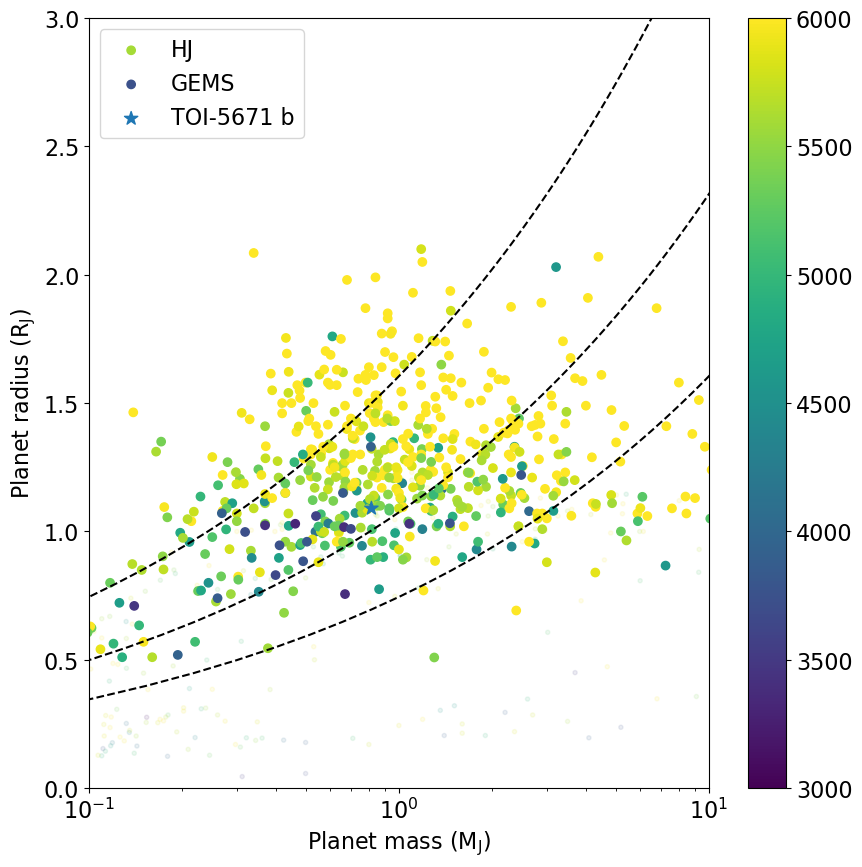

In [42]:
fig = plot_mass_radius(logx=True, logy=False, color='st_teff')
pl.xlim(1e-1,10)
pl.ylim(0,3)

In [44]:
from adjustText import adjust_text
import matplotlib.pyplot as pl
from matplotlib.ticker import ScalarFormatter
pl.style.use("default")
pl.rcParams['font.size'] = 16

def plot_2d(x, y, xx, yy, xlabel=None, ylabel=None, 
            logx=True, logy=True, show_labels=False):
    fig, ax = pl.subplots(figsize=(10,10))
    
    c='C0'
    idx_rv = rv2['pl_radj_reflink'].str.contains('CALCULATED')
    ax.scatter(rv2[x][~idx_rv], rv2[y][~idx_rv], label='RV (GEMS)', c=c)
    ax.scatter(rv1[x], rv1[y], label='RV (HJ)', c=c, marker='.')
    # ax.scatter(rv2[x][idx_rv], rv2[y][idx_rv], c=c, alpha=0.5)
    
    # ax.scatter(microlensing2[x], microlensing2[y], marker='o', label='microlensing', c='C1')
    # ax.scatter(imaging2[x], imaging2[y], label='imaging', c='C2')
    
    c='C3'
    idx_tr = transit2['pl_bmassj_reflink'].str.contains('CALCULATED')
    ax.scatter(transit2[x][~idx_tr], transit2[y][~idx_tr], label='transit (GEMS)', c=c)
    ax.scatter(transit1[x], transit1[y], label='transit (HJ)', c=c, marker='.')
    # ax.scatter(transit2[x][idx_tr], transit2[y][idx_tr], c=c, alpha=0.5)
    ax.plot(xx, yy, label='TOI-5671 b', ms=20, marker='*', ls='', c=c, zorder=100)

    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Giant planets (R>{Rpj_cut}"+r"R$_{\rm{J}}$) "+f"orbiting M dwarfs (Teff<{Teff_cut} K)")
    
    texts = []
    # for i, row in rv2.iterrows():
    #     txt = pl.text(row[x], row[y], row['pl_name'])
    #     texts.append(txt)
    
    if show_labels:
        for i, row in transit2.iterrows():
            txt = pl.text(row[x], row[y], row['pl_name'])
            texts.append(txt)
        adjust_text(texts, 
                    arrowprops=dict(arrowstyle="-", color='k', lw=0.5)
                   );
    
    # ax.xaxis.set_minor_formatter(ScalarFormatter())
    # ax.yaxis.set_minor_formatter(ScalarFormatter())
    ax.legend(loc='best')
    # fig.savefig("mass_radius.png")
    return fig

## Frequency

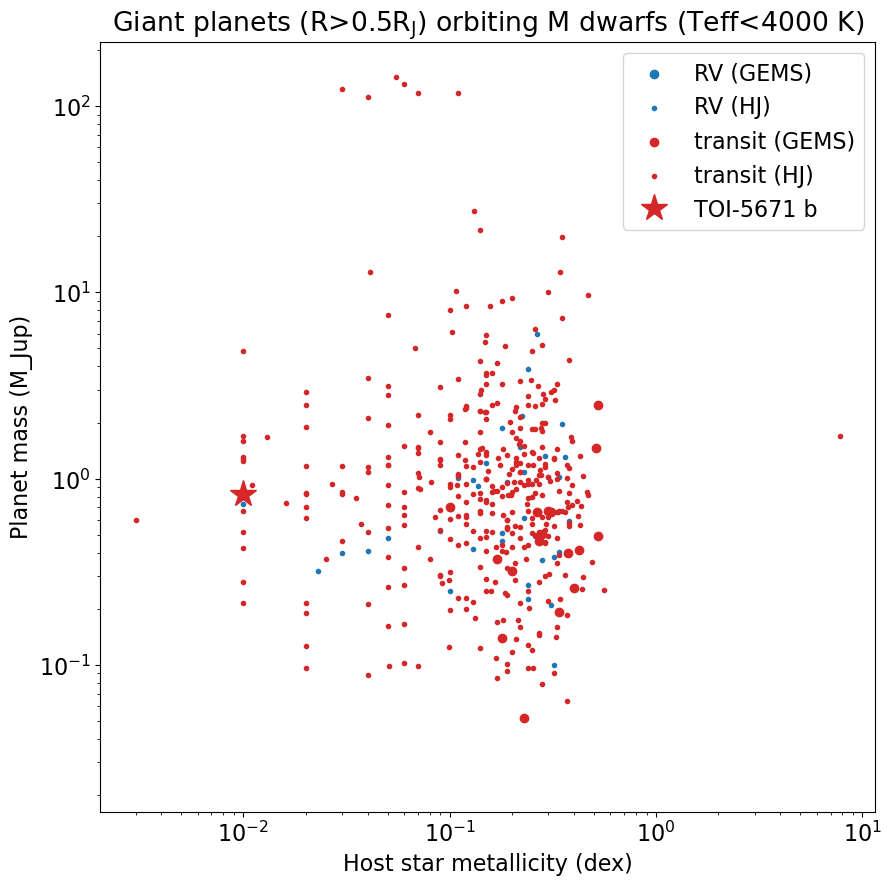

In [49]:
fig = plot_2d(x='st_met', y='pl_bmassj', 
              xx=0.01, yy=Mpj[0], 
              xlabel="Host star metallicity (dex)", 
              ylabel=r"Planet mass (M$_{\rm{J}}$)",
              show_labels=False
             )
# pl.axvline(10, 0, 1, ls='--', c='k')
# pl.axhline(1e3, 0, 1, ls='--', c='k')

## Differentiating characteristics between GEMS & HJ

* a/Rstar>10
* Teq<1000K

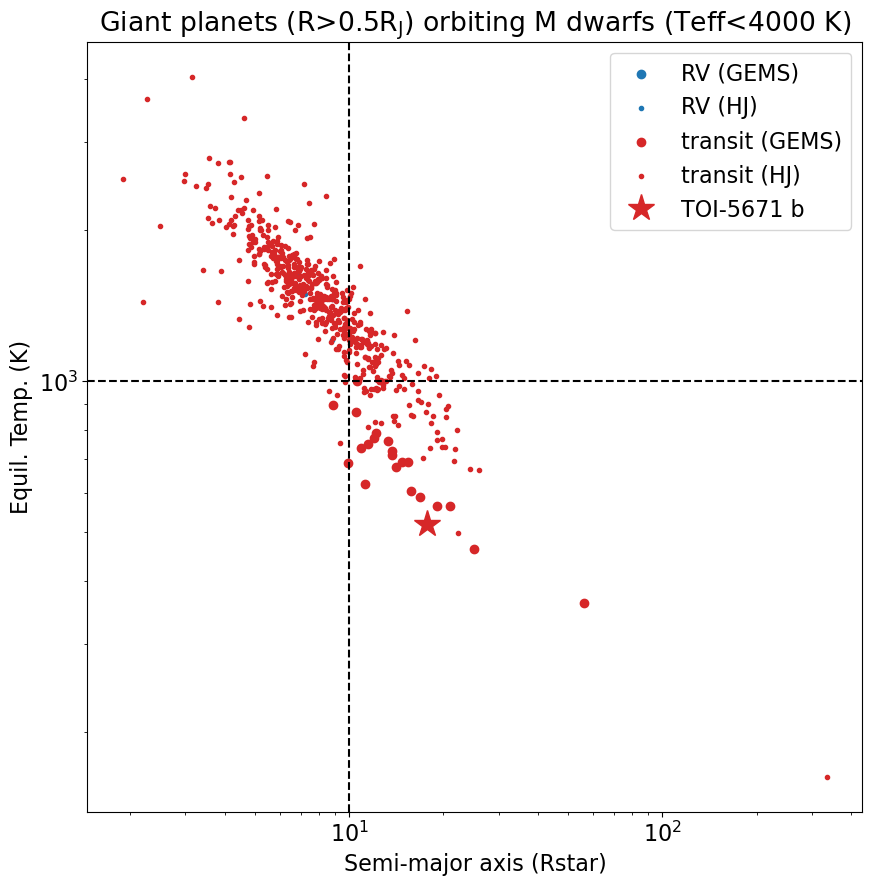

In [48]:
fig = plot_2d(x='pl_ratdor', y='pl_eqt', 
              xx=a_Rs[0], yy=Teq[0], 
              xlabel= "Semi-major axis (Rstar)",
              ylabel="Equil. Temp. (K)", 
              show_labels=False
             )
pl.axvline(10, 0, 1, ls='--', c='k')
pl.axhline(1e3, 0, 1, ls='--', c='k')

Can I place a dividing line (support vector) to separate the distribution into two?

## Mp-Rp

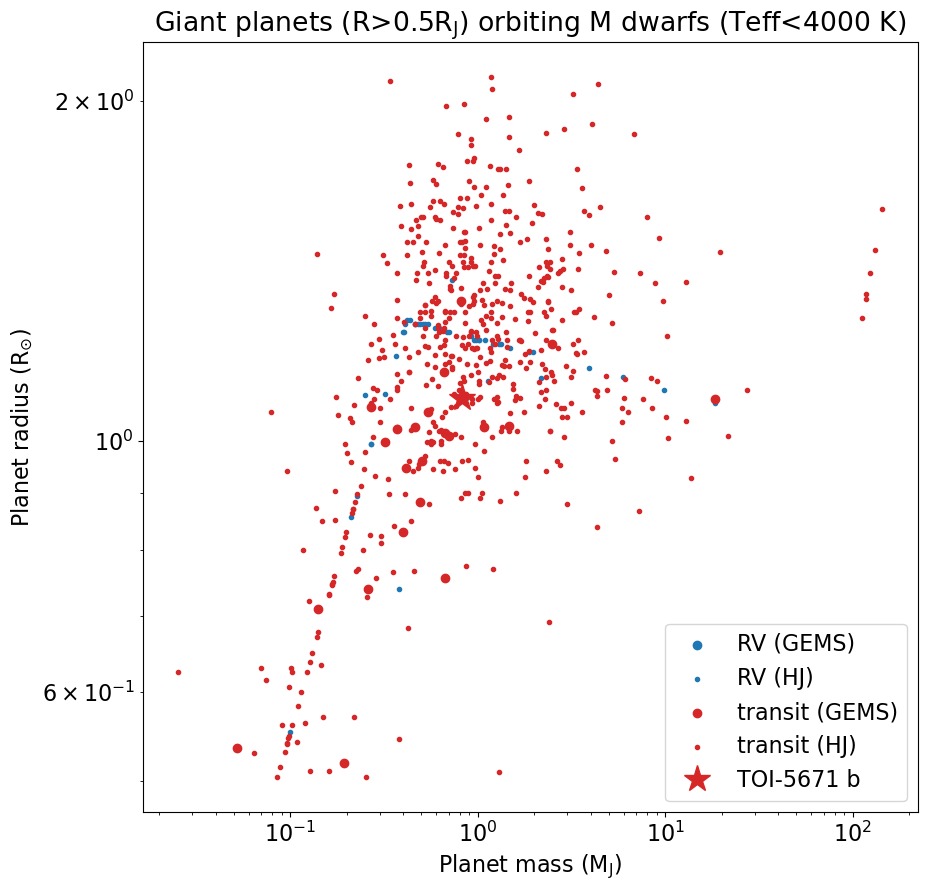

In [51]:
fig = plot_2d(x='pl_bmassj', y='pl_radj', 
              xx=Mpj[0], yy=Rpj[0],
              xlabel = r"Planet mass (M$_{\rm{J}}$)",
              ylabel = r"Planet radius (R$_{\odot}$)",
              show_labels=False
             )
# pl.axvline(10, 0, 1, ls='--', c='k')
# pl.axhline(1e3, 0, 1, ls='--', c='k')

## rhostar-rhop

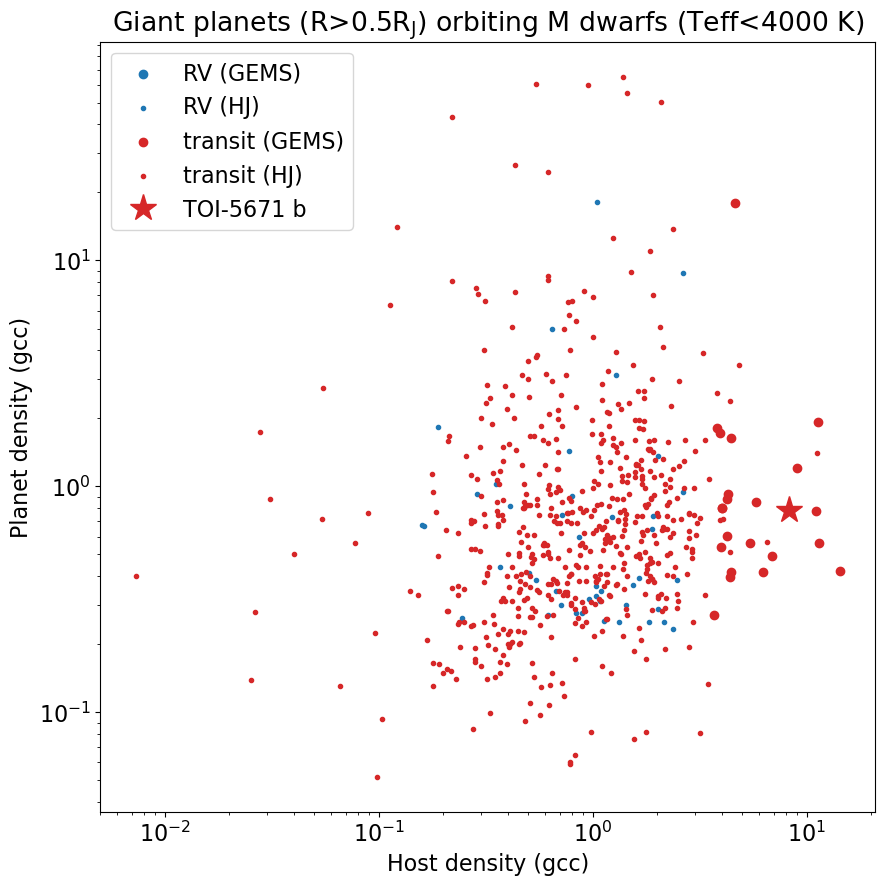

In [52]:
fig = plot_2d(x='st_dens', y='pl_dens',
              xx=rhostar[0], yy=rhop[0],
              xlabel="Host density (gcc)",
              ylabel="Planet density (gcc)",
              show_labels=False
             )
# pl.axvline(10, 0, 1, ls='--', c='k')
# pl.axhline(1e3, 0, 1, ls='--', c='k')

* denser (higher metallicity host stars) does not make more dense planets

## Rstar-Rp

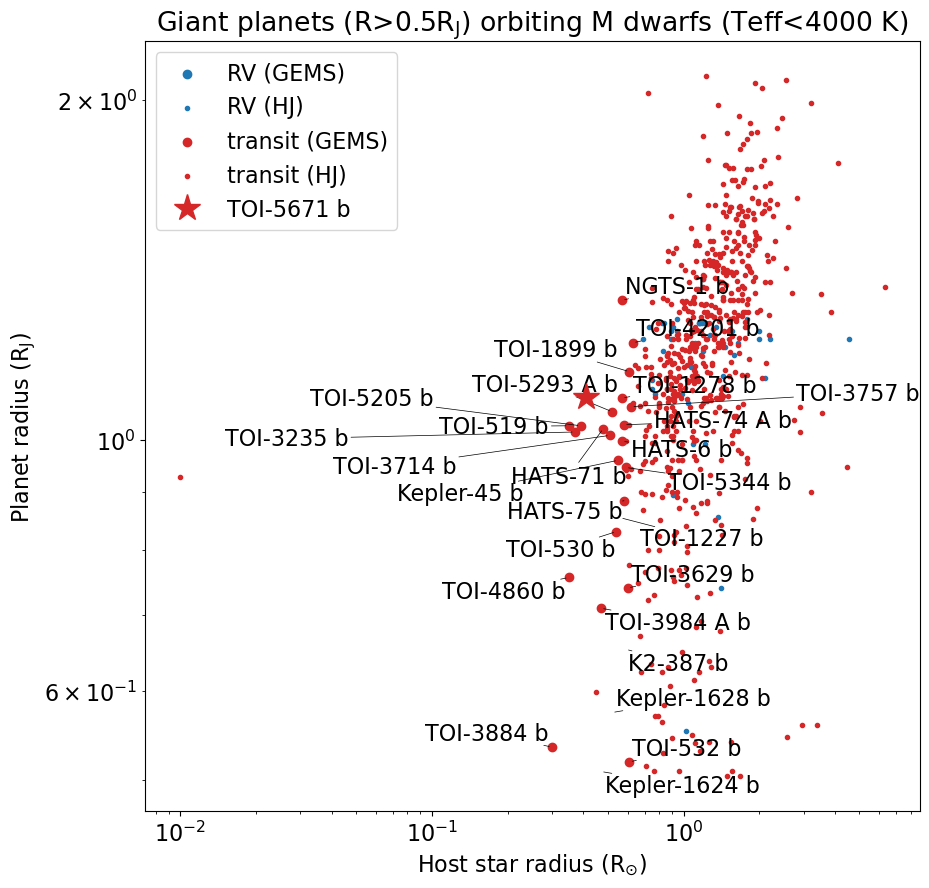

In [54]:
fig = plot_2d(x='st_rad', y='pl_radj',
             xx=Rstar[0], yy=Rpj[0],
             ylabel=r"Planet radius (R$_{\rm{J}}$)",
             xlabel=r"Host star radius (R$_{\odot}$)",
              show_labels=True
             )
# pl.axvline(10, 0, 1, ls='--', c='k')
# pl.axhline(1e3, 0, 1, ls='--', c='k')

## rhop-Mp

## P-Rs/Rp

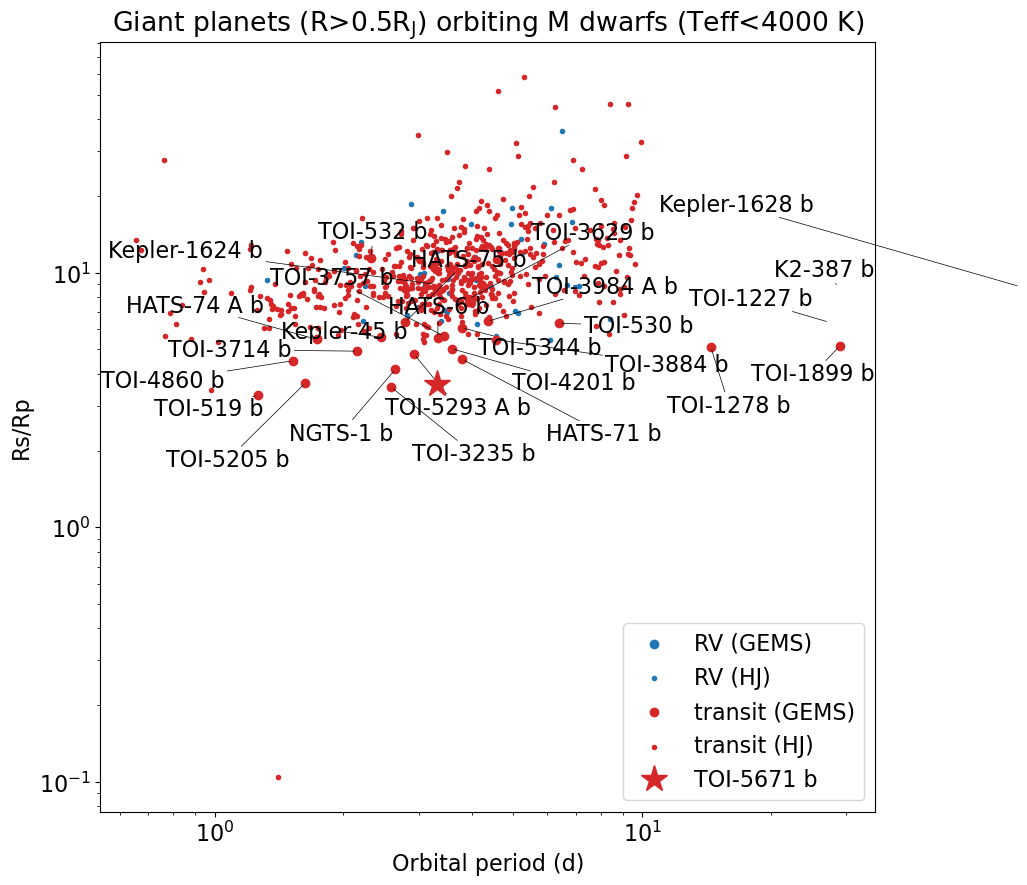

In [57]:
fig = plot_2d(x='pl_orbper', y='Rs/Rp',
            xx=Porb[0], yy=Rstar[0]/(Rpj[0]*u.Rjup.to(u.Rsun)),
            xlabel="Orbital period (d)",
            ylabel="Rs/Rp",
              show_labels=True
             )
# pl.axvline(10, 0, 1, ls='--', c='k')
# pl.axhline(1e3, 0, 1, ls='--', c='k')

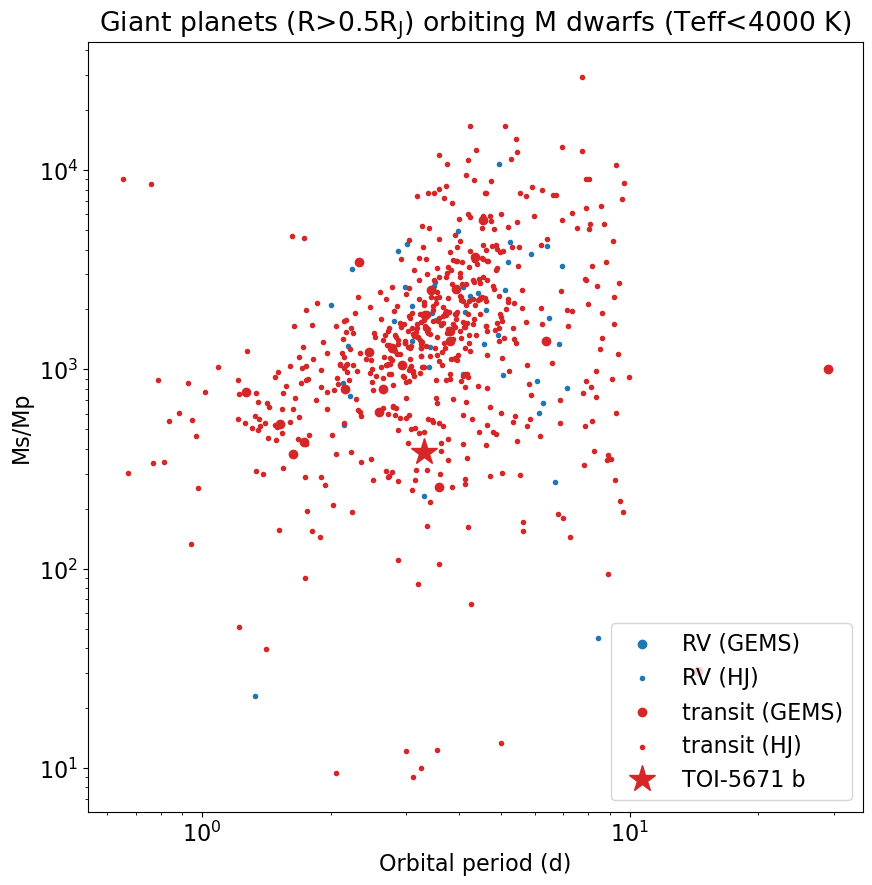

In [59]:
fig = plot_2d(x='pl_orbper', y='Ms/Mp',
              xx=Porb[0], yy=Mstar[0]/(Rpj[0]*u.Mjup.to(u.Msun)),
              xlabel="Orbital period (d)",
              ylabel="Ms/Mp",
              show_labels=False
             )
# pl.axvline(10, 0, 1, ls='--', c='k')
# pl.axhline(1e3, 0, 1, ls='--', c='k')